In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 14513, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 14513 (delta 19), reused 24 (delta 14), pack-reused 14477
Receiving objects: 100% (14513/14513), 13.60 MiB | 7.35 MiB/s, done.
Resolving deltas: 100% (9998/9998), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


 **YOLO-G: A Lightweight Network Model
for Improving the Performance
of Military Targets Detection**

In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 1.6 MB 37.4 MB/s 
Setup complete. Using torch 1.13.0+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="TBSZIcJvZGLN6tqEEfeO")
project = rf.workspace("night-vision-mmcmp").project("mul")
dataset = project.version(1).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 775 kB/s 
     |████████████████████████████████| 145 kB 66.1 MB/s 
     |████████████████████████████████| 178 kB 74.6 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 138 kB 78.8 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=87d7ac4159d98fb15ee00e495b44532a93d9d7843cf0f866dacffe8c9eba1034
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: certifi
    Found existing installation: certi

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Mul-1 in yolov5pytorch:: 100%|██████████| 9593/9593 [00:02<00:00, 3204.74it/s]


In [ ]:
%cd /content/yolov5
#after following the link above, recieve python code with these fields filled in
#from roboflow import Roboflow
#rf = Roboflow(api_key="YOUR API KEY HERE")
#project = rf.workspace().project("YOUR PROJECT")
#dataset = project.version("YOUR VERSION").download("yolov5")
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

/content/yolov5
names:
- Bird
- Drone
- Helicopter
- Plane
nc: 4
roboflow:
  license: CC BY 4.0
  project: mul
  url: https://universe.roboflow.com/night-vision-mmcmp/mul/dataset/1
  version: 1
  workspace: night-vision-mmcmp
test: ../test/images
train: Mul-1/train/images
val: Mul-1/valid/images


In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat //content/yolov5/models/yolov3.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [12]:
%%writetemplate /content/yolov5/models/custom_yoloG.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# darknet53 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [32, 3, 1]],  # 0
   [-1, 1, Conv, [64, 3, 2]],  # 1-P1/2
   [-1, 1, GhostBottleneck, [64]],
   [-1, 1, Conv, [128, 3, 2]],  # 3-P2/4
   [-1, 2, GhostBottleneck, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 5-P3/8
   [-1, 8, GhostBottleneck, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 7-P4/16
   [-1, 8, GhostBottleneck, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 9-P5/32
   [-1, 4, GhostBottleneck, [1024]],  # 10
  ]

# YOLOv3 head
head:
  [[-1, 1, GhostBottleneck, [1024, False]],
   [-1, 1, Conv, [512, 1, 1]],
   [-1, 1, Conv, [1024, 3, 1]],
   [-1, 1, Conv, [512, 1, 1]],
   [-1, 1, Conv, [1024, 3, 1]],  # 15 (P5/32-large)

   [-2, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 8], 1, Concat, [1]],  # cat backbone P4
   [-1, 1, GhostBottleneck, [512, False]],
   [-1, 1, GhostBottleneck, [512, False]],
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [512, 3, 1]],  # 22 (P4/16-medium)

   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P3
   [-1, 1, GhostBottleneck, [256, False]],
   [-1, 2, GhostBottleneck, [256, False]],  # 27 (P3/8-small)

   [[27, 22, 15], 1, Detect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

In [13]:
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 256 --batch 512 --epochs 500 --data {dataset.location}/data.yaml --hyp data/hyps/hyp.scratch-high.yaml  --cfg ./models/custom_yoloG.yaml --weights '' --name yoloG_results  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yoloG.yaml, data=/content/yolov5/Mul-1/data.yaml, hyp=data/hyps/hyp.scratch-high.yaml, epochs=500, batch_size=512, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yoloG_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 398 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1,

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

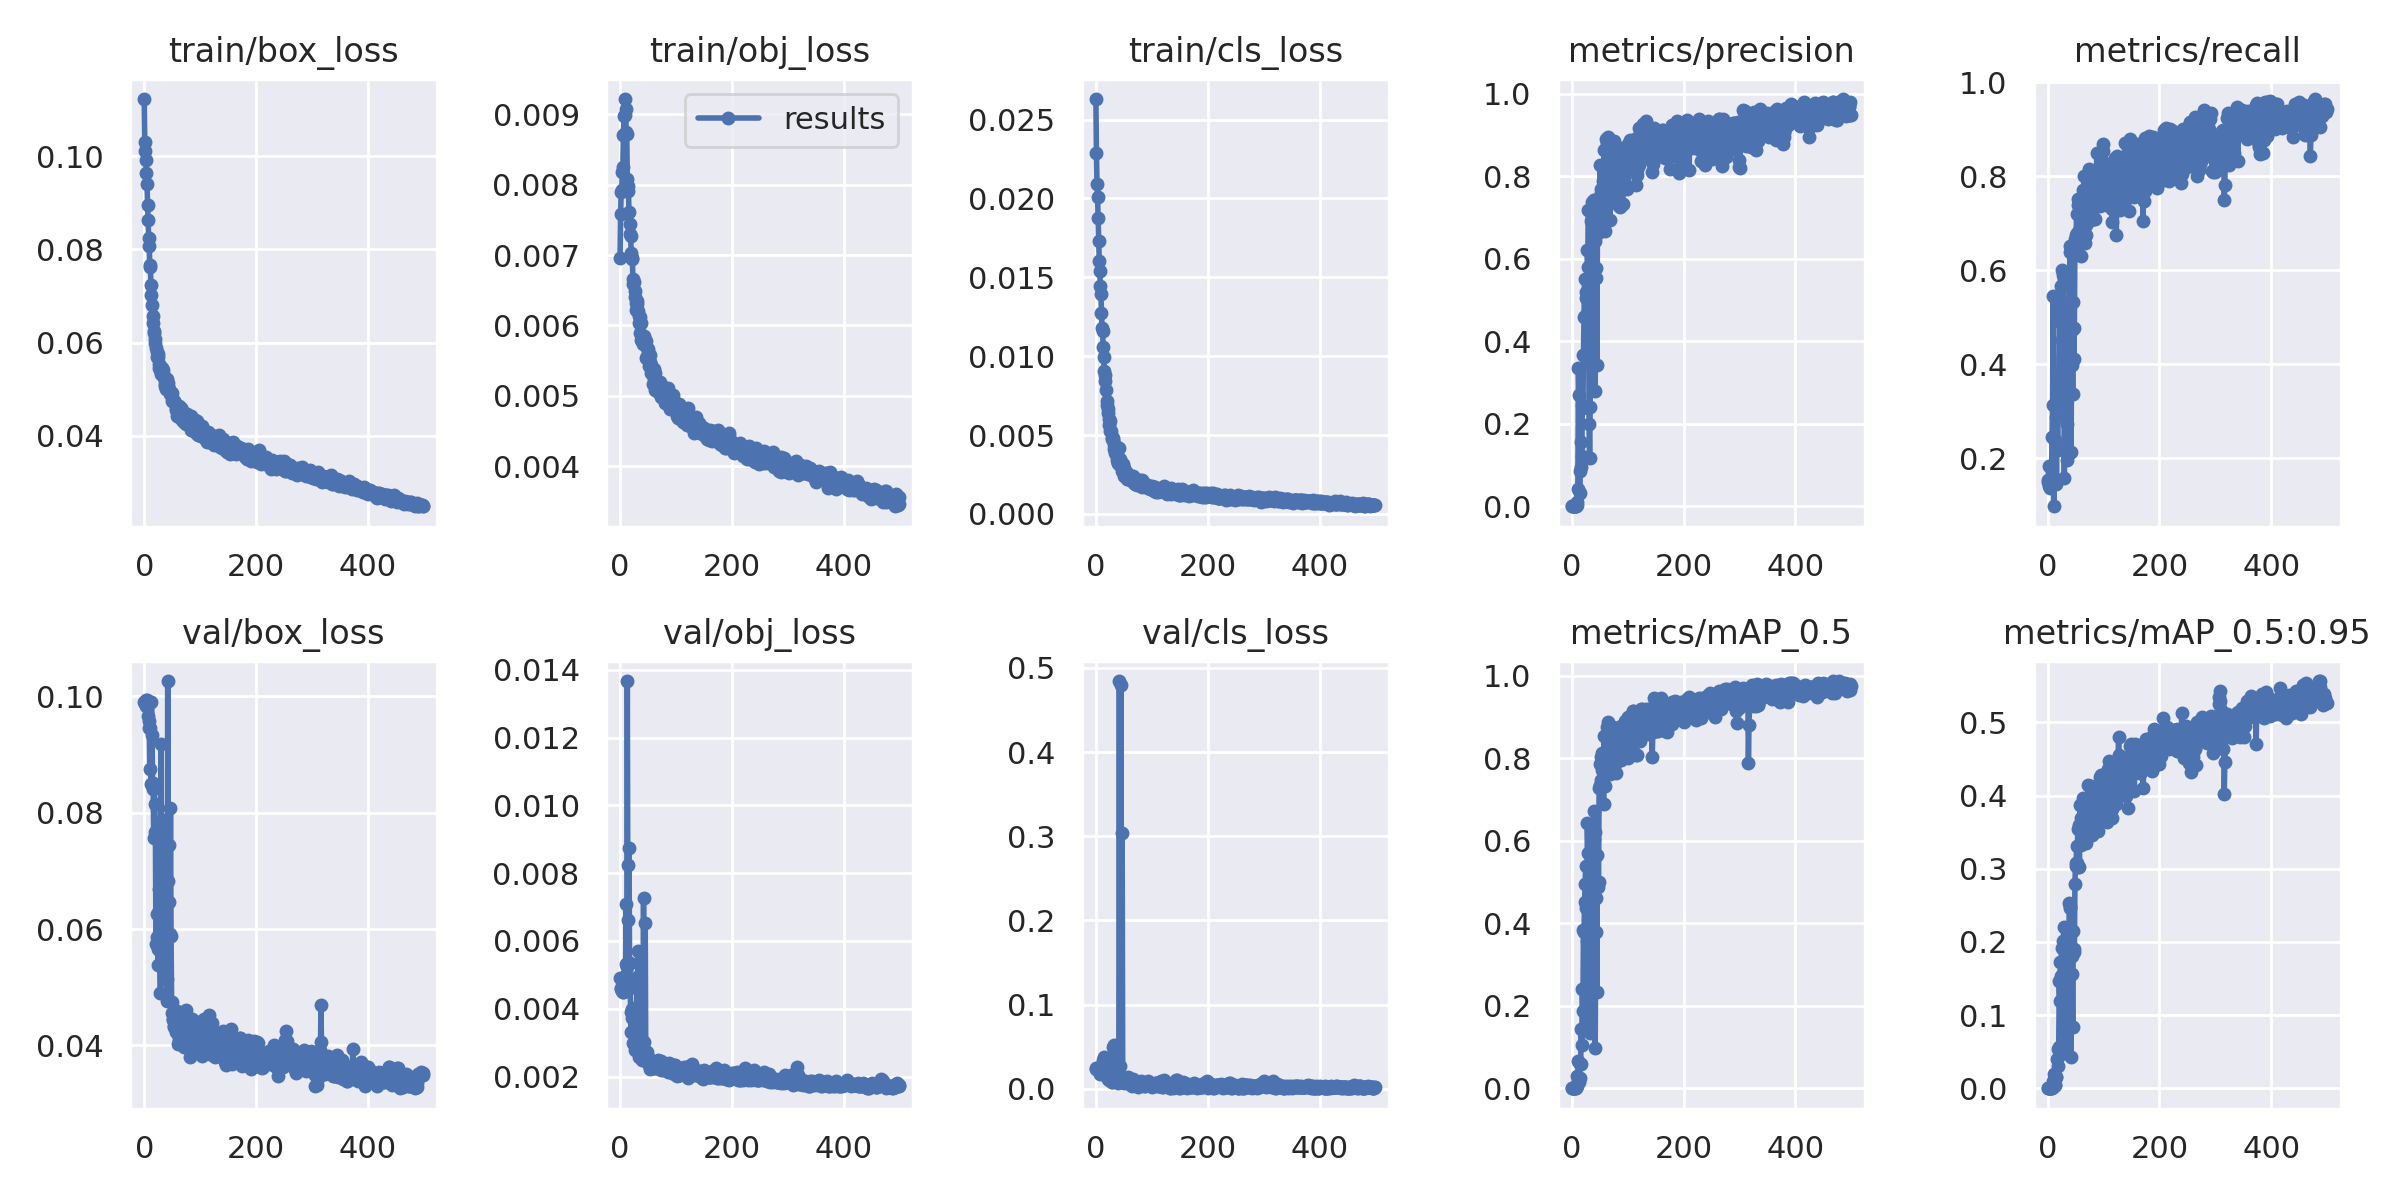

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yoloG_results/results.png', width=1000)  # view results.png

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/
%ls runs/train/yoloG_results/weights

train/
best.pt  last.pt


In [ ]:
######## Test Train image folder
#%cd /content/yolov5/
# Perform detection and save results
#!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 256 --conf 0.25 --source /content/yolov5/Mul-1/train/images

In [ ]:
######## Test Valid image folder
%cd /content/yolov5/
!python detect.py --weights runs/train/yoloG_results/weights/best.pt --img 256 --conf 0.25 --source /content/yolov5/Mul-1/valid/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/yolov5/Mul-1/valid/images, data=data/coco128.yaml, imgsz=[256, 256], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 366 layers, 3683817 parameters, 0 gradients, 8.1 GFLOPs
image 1/240 /content/yolov5/Mul-1/valid/images/00000000_0000000000916B52_w320_h256_pMono14_jpg.rf.0f68cc2e3ebc9f937375918bf07c7aeb.jpg: 256x256 1 Plane, Done. (0.015s)
image 2/240 /content/yolov5/Mul-1/valid/images/00000000_0000000001247F81_w320_h256_pMono14_jpg.rf.74825af883e555637a59d4a6e76536b6.jpg: 256x2

In [ ]:
#########Validate whole dataset
# Validate model and print evaluation metrics
!python val.py --weights runs/train/yoloG_results/weights/best.pt --data {dataset.location}/data.yaml --img 256 --half

val: data=/content/yolov5/Mul-1/data.yaml, weights=['runs/train/yolov5s_results/weights/best.pt'], batch_size=32, imgsz=256, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 366 layers, 3683817 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning '/content/yolov5/Mul-1/valid/labels.cache' images and labels... 240 found, 0 missing, 0 empty, 0 corrupt: 100% 240/240 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 8/8 [00:03<00:00,  2.03it/s]
                 all        240        269      0.988      0.926      0.983      0.556
                Bird        240         89      0.989      0.977      0.988      0.5

In [ ]:
##I have created a zip file:
!zip -r /content/yoloG.zip /content/yolov5/runs/
##Than I have downloded that zip file:
from google.colab import files
files.download("/content/yoloG.zip")